In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
%matplotlib auto
plt.style.use('ggplot')


Using matplotlib backend: module://ipympl.backend_nbagg


In [21]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


# Definición de funciones

In [26]:
NL1, NL2, TIPO = 0, 1, 2     # Nodo local 1, Nodo local 2
X, Y, TH       = 0, 1, 2     # TH = theta
b, h           = 0, 1        # b = base, h = altura

def espectro_NSR10(param_loc, param_din, h, grafica = False):
    '''
    param_loc -> diccionario
    Aa  :   # A.2.3-2. Coeficiente de aceleración horizontal pico efectiva.
    Av  :   # A.2.3-2. Coeficiente de velocidad horizontal pico efectiva.
    Fa  :   # A.2.4-3. Coeficiente de amplificación de la aceleración para periodos cortos.
    Fv  :   # A.2.4-4. Coeficiente de amplificación de la aceleración en la zona de periodos intermedios.
    I   :   # A.2.5-1. Coeficiente de importancia.
    
    param_din -> diccionario
    Ct  :   # A.2.5-1.  Coeficiente para el cálculo del periodo.
    alfa:   # A.2.5-1.  Exponente para el cálculo del periodo.
    
    grafica : boolean (True or False)
    '''
    Aa, Av, Fa, Fv, I = param_loc.values()
    Ct, alfa = param_din.values()

    # Cálculo de periodos
    T_a = Ct*(h**alfa)  # [s] Periodo fundamental aproximado, A.4.2-3.
    T_0 = 0.1*(Av*Fv)/(Aa*Fa)   # [s] Periodo inicial.
    T_C = 0.48*(Av*Fv)/(Aa*Fa)  # [s] Periodo corto.
    T_L = 2.4*Fv                # [s] Periodo largo.        Figura A.2.6-1.

    # Aceleración para el periodo fundamental aproximado.
    if T_a < T_C:
        S_a = 2.5*Aa*Fa*I
    elif T_a > T_L:
        S_a = 1.2*Av*Fv*T_L*I/T_a**2
    else:
        S_a = 1.2*Av*Fv*I/T_a
    # Valor del exponente
    if T_a <= 0.5:
        k = 1
    elif T_a > 2.5:
        k = 2
    else:
        k = 0.75+0.5*T_a
    resultados = {
        'S_a': S_a,
        'T_a': T_a,
        'k': k,
        'T_0': T_0,
        'T_C': T_C,
        'T_L': T_L
    }
    if grafica:
        # Gráfica del espectro de aceleraciones 
        t_espectro = np.linspace(0, 10, 100)
        sa_espectro = np.zeros_like(t_espectro)
        for t,i in zip(t_espectro,range(len(t_espectro))):
            if t < T_C:
                sa_espectro[i] = 2.5*Aa*Fa*I
            elif t > T_L:
                sa_espectro[i] = 1.2*Av*Fv*T_L*I/t**2
            else:
                sa_espectro[i] = 1.2*Av*Fv*I/t
        plt.figure()
        plt.plot(t_espectro, sa_espectro, '-k')
        plt.plot(T_a, S_a, '.b', ms=10)
        plt.title('Espectro de aceleraciones A.2 NSR-10')
        plt.xlabel(r'$T\quad [s]$')
        plt.ylabel(r'$S_a[g]$')
        plt.text(1.1*T_a, S_a, r"$(T_a,S_a)$", fontsize=10, color='b')
        plt.grid(visible=True)
        plt.show()
    return resultados
def MFHE(masa_pisos, h_acumu, S_a, k):
    masa_total = np.sum(masa_pisos)   # kN
    Vs = masa_total*(S_a)     # kN
    m_h_k = masa_pisos*(h_acumu**k) # kN
    C_vx = m_h_k/np.sum(m_h_k)      # [%]
    F = np.reshape(Vs*C_vx, (len(masa_pisos),1))              # kN
    return F
def matriz_rigidez_portico(datos_portico, grafica=False):
    def reducir_matriz(K):
        # Primero se reduce por las filas
        orden = np.shape(K)[0]
        K_f = np.zeros((N_PISOS, orden))
        for i in range(N_PISOS):
            for j in range(int(orden/N_PISOS)):
                K_f[i] += K[i+N_PISOS*j]
        # Ahora se reduce por columnas
        K_r = np.zeros((N_PISOS, N_PISOS))
        for i in range(N_PISOS):
            for j in range(int(orden/N_PISOS)):
                K_r[:,i] += K_f[:,i+N_PISOS*j]
        return K_r
    xnod = datos_portico['xnod']
    barra = datos_portico['barra']
    apoyos = datos_portico['apoyos']
    COL = datos_portico['COL']
    VIG = datos_portico['VIG']
    E_c = datos_portico['E']
    n_porticos = datos_portico['n_porticos']
    LaG = barra[:, [NL1, NL2]]  # local a global
    tipo = barra[:, TIPO]        # material - 1 columna - 2 viga
    nno  = xnod.shape[0] # número de nodos (numero de filas de xnod)
    nbar = LaG.shape[0]  # número de EFs (numero de filas de LaG)
    ngdl = 3*nno         # número de grados de libertad (tres por nodo)
    # coordenadas de los nodos de cada barra
    x1 = np.zeros(nbar) 
    y1 = np.zeros(nbar)
    x2 = np.zeros(nbar)
    y2 = np.zeros(nbar)
    for e in range(nbar):
        x1[e] = xnod[LaG[e,NL1], X];  x2[e] = xnod[LaG[e,NL2], X]
        y1[e] = xnod[LaG[e,NL1], Y];  y2[e] = xnod[LaG[e,NL2], Y]

    #                  área       inercias_y       módulo de elasticidad
    #                  A(m^2)        I(m^4)           E(kN/m^2)
    props = np.array([[COL[b]*COL[h],   (COL[b]*COL[h]**3)/12,     E_c],
                    [VIG[b]*VIG[h],   (VIG[b]*VIG[h]**3)/12,     E_c]])

    A = props[:,0];   I = props[:,1];   E = props[:,2]

    # gdl: grados de libertad
    # fila = nodo
    # col1 = gdl en dirección x
    # col2 = gdl en dirección y
    # col3 = gdl en dirección angular antihoraria
    gdl = np.arange(ngdl).reshape(nno, 3)  # nodos vs grados de libertad

    # Ángulo, área y longitud por barra
    area = np.zeros(nbar)
    ang = np.zeros(nbar)
    long = np.zeros(nbar)
    for e in range(nbar):
        long[e] = np.hypot(x2[e]-x1[e], y2[e]-y1[e]) # m 
        ang[e] = np.arctan2(y2[e]-y1[e], x2[e]-x1[e]) # radianes
        area[e] = A[barra[e,TIPO]]          # m3
    if grafica:
        # Se dibuja la estructura junto con su numeración
        plt.figure(1)
        for e in range(nbar):
            plt.plot(xnod[LaG[e,:],X], xnod[LaG[e,:],Y], 'k-')
            # Calculo la posición del centro de gravedad de la barra
            cgx = (xnod[LaG[e,NL1],X] + xnod[LaG[e,NL2],X])/2
            cgy = (xnod[LaG[e,NL1],Y] + xnod[LaG[e,NL2],Y])/2
            plt.text(cgx, cgy, str(e+1), color='red')

            plt.plot(xnod[:,X], xnod[:,Y], 'ro')
            for n in range(nno):
                plt.text(xnod[n,X], xnod[n,Y], str(n+1), color='k')
        plt.axis('equal')
        plt.grid(visible=True, which='both', color='0.65',linestyle='-')
        plt.title('Numeración del pórtico')
        plt.show()

    # ensamblo la matriz de rigidez global
    K   = np.zeros((ngdl,ngdl))  # separo memoria
    Ke  = nbar*[None]
    T   = nbar*[None]
    idx = np.zeros((nbar,6), dtype=int)

    for e in range(nbar): # para cada barra
        # saco los 6 gdls de la barra e
        idx[e] = np.r_[gdl[LaG[e,NL1],:], gdl[LaG[e,NL2],:]]
        L = long[e]
        # matriz de transformación de coordenadas para la barra e
        c = np.cos(ang[e]);   s = np.sin(ang[e])  # seno y coseno de la inclinación
        T[e] = np.array([[ c,  s,  0,  0,  0,  0],
                            [-s,  c,  0,  0,  0,  0],
                            [ 0,  0,  1,  0,  0,  0],
                            [ 0,  0,  0,  c,  s,  0],
                            [ 0,  0,  0, -s,  c,  0],
                            [ 0,  0,  0,  0,  0,  1]])
        # matriz de rigidez local expresada en el sistema de coordenadas locales
        # para la barra e
        AE = A[tipo[e]]*E[tipo[e]];       L2=L**2
        EI = E[tipo[e]]*I[tipo[e]];       L3=L**3
        Kloc = np.array([
                [ AE/L,   0      ,   0      ,  -AE/L,    0      ,   0      ],  
                [ 0   ,  12*EI/L3,   6*EI/L2,   0   ,  -12*EI/L3,   6*EI/L2],
                [ 0   ,   6*EI/L2,   4*EI/L ,   0   ,   -6*EI/L2,   2*EI/L ],
                [-AE/L,   0      ,   0      ,   AE/L,    0      ,   0      ],
                [ 0   , -12*EI/L3,  -6*EI/L2,   0   ,   12*EI/L3,  -6*EI/L2],
                [ 0   ,   6*EI/L2,   2*EI/L ,   0   ,   -6*EI/L2,   4*EI/L ]])

        # matriz de rigidez local en coordenadas globales
        Ke[e] = T[e].T @ Kloc @ T[e]
        K[np.ix_(idx[e],idx[e])] += Ke[e] # ensambla Ke{e} en K global

    # grados de libertad del desplazamiento conocidos (c) y desconocidos (d)
    c = np.array([gdl[ij] for ij in apoyos])

    #c = apoyos[:,0].astype(int)
    d = np.setdiff1d(np.arange(ngdl), c)
    gdl_nc = np.setdiff1d(d, np.union1d(gdl[:,Y], gdl[:,TH]))
    gdl_c = np.setdiff1d(d, gdl_nc)

    K0 = K[ np.ix_( gdl_nc, gdl_nc )]
    K1 = K[ np.ix_( gdl_nc, gdl_c ) ] 
    K2 = K[ np.ix_( gdl_c, gdl_nc ) ] 
    K3 = K[ np.ix_( gdl_c, gdl_c )  ]

    K_condensada = (K0 - K1 @ np.linalg.inv(K3) @ K2)*n_porticos
    # Ahora lo que resta es sumar los grados de libertad por cada piso para así reducir la matriz
    return reducir_matriz(K_condensada)
def analisis_modal(M, K):
    '''
    M: Matriz de masa
    K: Matriz de rigidez condensada
    '''
    # lam = ome^2
    # ([K]-lam[M]){Phi} = {0}
    # [K]{Phi} = lam[M]{Phi}
    # Premultiplicando por [M]**-1
    # [M]**-1[K]{Phi}=lam[I]{Phi}
    # (([M]**-1[K])-lam[I]){Phi} = {0}
    # Es decir, el problema se reduce a hallar los valores y vectores propios de [M]**-1[K]
    lams, vectores = np.linalg.eig(np.linalg.inv(M) @ K)
    # Se ordena
    idx = np.argsort(lams)
    lams = lams[idx]
    vectores = vectores[:,idx]
    # Cálculo de vibraciones, frecuencias y periodos
    ome_i = np.sqrt(lams)   # [rad/s]   Vector de frecuencias angulares.       
    T_i  = 2*np.pi/ome_i    # [s]       Vector de periodos de la estructura.
    f_i  = 1/T_i            # [Hz]      Vector de frecuencias.

    # MATRIZ MODAL
    Phi = np.zeros_like(K)

    for j in range(N_PISOS):
        # Se calcula el vector de amplitudes del movimiento armónico
        Phi_j = vectores[:,j]
        # Norma respecto a la masa
        r_j = Phi_j.T @ M @ Phi_j
        # Se agrega el vector normalizado en la matriz modal
        Phi[:,j] = Phi_j/np.sqrt(r_j)
    compr_lams = Phi.T @ K @ Phi
    compr_Id = Phi.T @ M @ Phi
  
    print('Comprobación frecuencias')
    print(compr_lams.round(3))
    print('Comprobación identidad')
    print(compr_Id.round(3))

    # PARTICIPACIÓN MODAL
    alfa = Phi.T @ M @ np.ones((N_PISOS,1))
    M_mod_efectiva = alfa**2
    participacion_masa = M_mod_efectiva/np.sum(M_mod_efectiva)

    return Phi, ome_i, M_mod_efectiva, participacion_masa
def T_Rayleigh(M, F, U):
    return 2*np.pi*np.sqrt(np.sum(M*(U/100)**2)/np.sum(F*(U/100)))
def ADLTH(K, Phi, alfa, sismo, omega, xi):
    ''' ANÁLISIS DINÁMICO LINEAL TIEMPO HISTORIA
    Resolución de las ecuaciones desacopladas para cada instante de tiempo
    
        eta'' + 2 xi omega eta' + omega² eta = - alfa x_0''
        eta'' + p(t) eta' + q(t) eta = F(T)
    '''
    # Definimos las funciones F, p y q.
    def F(t):
        F = -alfa[modo]*sismo[i,1]
        return F

    def p(t):
        p = 2*xi*omega[modo]
        return p

    def q(t):
        q = omega[modo]**2
        return q

    # Para aprovechar la potencialidad de python utilizaremos un único vector cuyas componentes
    # serán la posicíon y la velocidad. En este caso lo llamamos x.
    # Definimos las derivadas de la posición x[0] y de la velocidad x[1]
        
    def dxdt(t,x):
        deriv = np.array([0.,0.])
        deriv[0] = x[1]
        deriv[1] = F(t) - p(t) * x[1] - q(t) * x[0] # la derivada de la velocidad
                                                    # se puede obtener a partir de la ecuación diferencial
        return deriv

    # Definimos una función que mediante el algoritmo de Runge-Kutta de 4to orden nos devuelve
    # la posición y la velocidad en t+h. Se le debe proporcionar x(t) y las derivadas en t. 
    def rk4(deriv,h,x,t):
        hh = h/2.
        h6 = h/6.
        th = t+hh
        xt = x+hh*deriv
        dxt = dxdt(th,xt)
        xt = x+hh*dxt
        dxm = dxdt(th,xt)
        xt = x+h*dxm
        dxm = dxt+dxm
        dxt = dxdt(t+h,xt)
        conf_th = x+h6*(deriv+dxt+2.*dxm)   
        return conf_th
    # Este es el cuerpo de cálculo
    instantes = len(sismo[:,0])
    modos = Phi.shape[0]
    eta = np.zeros((modos, instantes))
    h=sismo[1,0]               # paso temporal
    for modo in range(modos):
        x=np.array([0.,0.]) # condiciones iniciales
        traj = x              # traj almacenará la posición y la velocidad en función del tiempo
        for i in range(instantes):
            t = sismo[i,0]             
            deriv = dxdt(t,x)        # calculamos las derivadas en tiempo t
            x_new = rk4(deriv,h,x,t) # las nuevas posición y velocidad calculadas mediante RK4
            traj = np.vstack([traj,x_new]) # almacenamos posición y velocidad
            x = x_new                     # las nuevas condiciones iniciales para el paso posterior
                                        # serán las obtenidas luego de la evolución
        eta[modo,:] = traj[1:,0]
    U = Phi @ eta
    U_mod = [None]*instantes
    F_mod = [None]*instantes
    for i in range(instantes):
        for modo in range(modos):
            U_m = [None]*modos
            F_m = [None]*modos
            U_m[modo] = Phi[:,modo] * eta[modo,i]
            F_m[modo] = K @ (U_m[modo])
        U_mod[i] = U_m
        F_mod[i] = F_m
    F = K @ U
    V = np.ones((1, modos))@F
    Mom = h_acumu.T @ F
    # etap = traj[1:,1]
    # etapp = alfa*sismo[:,1]-2*xi*omega*etap-omega**2*eta
    return eta, U, F, V, Mom, U_mod, F_mod

In [27]:
N_PISOS = 6
g = 9.80665 # m/s²
# Se asume que se tiene un edificio de concreto reforzado
fpc = 21 # MPa
E_c = 4700*np.sqrt(fpc)*1000  # [kN/m²]
h_entrepiso = 3.5
D_losa = 460                # kgf/m²
D_cub = D_losa/2            # kgf/m²
Lu_dirY = np.array([7,7])         # [m] Luces en dirección Y
Lu_dirX = np.array([9,9,9]) # [m] Luces en dirección X
LY = np.sum(Lu_dirY) # [m] Longitud total de la losa en dirección X
LX = np.sum(Lu_dirX) # [m] Longitud total de la losa en dirección Y
A_losa = LX*LY       # [m²]
masa_pisos = np.ones(N_PISOS)*D_losa
masa_pisos[-1] = D_cub
masa_pisos = masa_pisos*A_losa*(g/1000)    # kN
M = np.diag(masa_pisos/g) # kN*s²/m        # MATRIZ DE MASA
np.savetxt("M.csv", M)
h_acumu = (np.arange(N_PISOS)+1)*h_entrepiso # m
# Derivas entre el 0.95% y el 1%
DeltaMAX = 0.01*h_entrepiso*100  # [cm]
DeltaMAXmin = 0.0095*h_entrepiso*100 # [cm]

# Dimensiones de los elementos del pórtico np.array([b, h])
# LA BASE DE LA COLUMNA SE ALINEA CON EL EJE X DE LA PLANTA
COL = np.array([0.85, 0.7])
VIG = np.array([0.4, 0.6])

# Ciudad = Manizales, Grupo de uso = I, Suelo = D
param_loc = {
    'Aa':0.25,
    'Av':0.25,
    'Fa': 1.3,
    'Fv': 1.9,
    'I': 1.0
}
# Parámetros dinámicos para una estructura con pórticos de concreto. 
param_din = {
    'Ct': 0.047,
    'alfa': 0.90
}

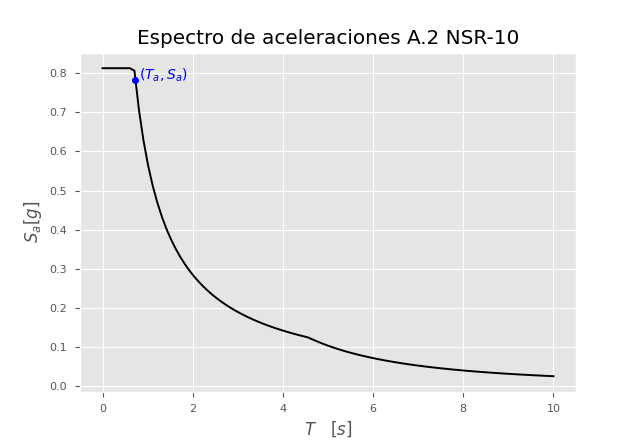

Propiedades mecánicas del material:
   E= 21538105.766 kN/m²
Cargas muertas del pórtico:
   D Losa     = 460 kgf/m²
   D Cubierta = 230.0 kgf/m²

PERIODO Y ACELERACIÓN DE LA ESTRUCTURA: 
   T_a = 0.72794 s
   S_a = 0.78303(g)



In [28]:
# [Sa, T_a, k, T_0, T_C, T_L]
espectro_norma_x = espectro_NSR10(param_loc, param_din, h_entrepiso*N_PISOS, True)
T_a = espectro_norma_x['T_a']
S_a = espectro_norma_x['S_a']
k = espectro_norma_x['k']
print(f'Propiedades mecánicas del material:\n\
   E= {E_c:.3f} kN/m²')
print(f'Cargas muertas del pórtico:\n\
   D Losa     = {D_losa} kgf/m²\n\
   D Cubierta = {D_cub} kgf/m²\n')
print(f'PERIODO Y ACELERACIÓN DE LA ESTRUCTURA: \n\
   T_a = {T_a:.5f} s\n\
   S_a = {S_a:.5f}(g)\n')

In [6]:
F = MFHE(masa_pisos, h_acumu, S_a, k)           # kN
print('MÉTODO DE LA FUERZA HORIZONTAL EQUIVALENTE:\n\
(se desprecia la masa aportada por las vigas y columnas)')
print(f'F = \n{np.round(F,3)}')

MÉTODO DE LA FUERZA HORIZONTAL EQUIVALENTE:
(se desprecia la masa aportada por las vigas y columnas)
F = 
[[ 350.776]
 [ 759.22 ]
 [1192.691]
 [1643.259]
 [2106.982]
 [1290.733]]


In [7]:
datos_portico_X = {
    'xnod' : np.array([
        [0, 0],   # coordenadas de cada nodo [x, y]
        [0, 3.5],
        [0, 7.0],
        [0, 10.5],
        [0, 14],
        [0, 17.5],
        [0, 21.0],
        [9, 0],   # coordenadas de cada nodo [x, y]
        [9, 3.5],
        [9, 7.0],
        [9, 10.5],
        [9, 14],
        [9, 17.5],
        [9, 21.0],
        [18, 0],   # coordenadas de cada nodo [x, y]
        [18, 3.5],
        [18, 7.0],
        [18, 10.5],
        [18, 14],
        [18, 17.5],
        [18, 21.0],
        [27, 0],   # coordenadas de cada nodo [x, y]
        [27, 3.5],
        [27, 7.0],
        [27, 10.5],
        [27, 14],
        [27, 17.5],
        [27, 21.0]]),
    'barra' : np.array([
        # LaG: local a global: matriz que relaciona nodos locales y globales
        # fila = barra
        # col1 = nodo global asociado a nodo local 1
        # col2 = nodo global asociado a nodo local 2
        # (se lee la barra x va del nodo i al nodo j)
        # NL1   NL2  TIPO -> 1 COL, 2 VIG
        [1,    2,   1],
        [2,    3,   1],
        [3,    4,   1],
        [4,    5,   1],
        [5,    6,   1],
        [6,    7,   1],
        [8,    9,   1],
        [9,   10,   1],
        [10,  11,   1],
        [11,  12,   1],
        [12,  13,   1],
        [13,  14,   1],
        [15,  16,   1],
        [16,  17,   1],
        [17,  18,   1],
        [18,  19,   1],
        [19,  20,   1],
        [20,  21,   1],
        [22,  23,   1],
        [23,  24,   1],
        [24,  25,   1],
        [25,  26,   1],
        [26,  27,   1],
        [27,  28,   1],
        [2,    9,   2],
        [3,   10,   2],
        [4,   11,   2],
        [5,   12,   2],
        [6,   13,   2],
        [7,   14,   2],
        [9,   16,   2],
        [10,  17,   2],
        [11,  18,   2],
        [12,  19,   2],
        [13,  20,   2],
        [14,  21,   2],
        [16,  23,   2],
        [17,  24,   2],
        [18,  25,   2],
        [19,  26,   2],
        [20,  27,   2],
        [21,  28,   2]])-1,
    'apoyos' : [# Se resta uno por convención de Python
        (1 -1,   X),
        (1 -1,   Y),
        (1 -1,   TH),
        (8 -1,   X),
        (8 -1,   Y),
        (8 -1,   TH),
        (15-1,   X),
        (15-1,   Y),
        (15-1,   TH),
        (22-1,   X),
        (22-1,   Y),
        (22-1,   TH)
    ],
    'COL': np.array([COL[h], COL[b]]), # Para considerar en el momento de inercia, la orientación de la columna
    'VIG': VIG,
    'E'  : E_c,
    'n_porticos': 3
}
datos_portico_Y = {
    'xnod' : np.array([
        [0, 0],   # coordenadas de cada nodo [x, y]
        [0, 3.5],
        [0, 7.0],
        [0, 10.5],
        [0, 14],
        [0, 17.5],
        [0, 21.0],
        [7, 0],   # coordenadas de cada nodo [x, y]
        [7, 3.5],
        [7, 7.0],
        [7, 10.5],
        [7, 14],
        [7, 17.5],
        [7, 21.0],
        [14, 0],   # coordenadas de cada nodo [x, y]
        [14, 3.5],
        [14, 7.0],
        [14, 10.5],
        [14, 14],
        [14, 17.5],
        [14, 21.0]]),
    'barra' : np.array([
        # LaG: local a global: matriz que relaciona nodos locales y globales
        # fila = barra
        # col1 = nodo global asociado a nodo local 1
        # col2 = nodo global asociado a nodo local 2
        # (se lee la barra x va del nodo i al nodo j)
        # NL1   NL2  TIPO -> 1 COL, 2 VIG
        [1,    2,   1],
        [2,    3,   1],
        [3,    4,   1],
        [4,    5,   1],
        [5,    6,   1],
        [6,    7,   1],
        [8,    9,   1],
        [9,   10,   1],
        [10,  11,   1],
        [11,  12,   1],
        [12,  13,   1],
        [13,  14,   1],
        [15,  16,   1],
        [16,  17,   1],
        [17,  18,   1],
        [18,  19,   1],
        [19,  20,   1],
        [20,  21,   1],
        [2,    9,   2],
        [3,   10,   2],
        [4,   11,   2],
        [5,   12,   2],
        [6,   13,   2],
        [7,   14,   2],
        [9,   16,   2],
        [10,  17,   2],
        [11,  18,   2],
        [12,  19,   2],
        [13,  20,   2],
        [14,  21,   2]])-1,
    'apoyos' : [
        (1 -1,   X),
        (1 -1,   Y),
        (1 -1,   TH),
        (8 -1,   X),
        (8 -1,   Y),
        (8 -1,   TH),
        (15-1,   X),
        (15-1,   Y),
        (15-1,   TH)
    ],
    'COL': COL,
    'VIG': VIG,
    'E'  : E_c,
    'n_porticos': 4
}

# ES IMPORTANTE NUMERAR EN ORDEN PRIMERO LAS COLUMNAS Y LUEGO LAS VIGAS
K_c_x = matriz_rigidez_portico(datos_portico_X) # kN/m
K_c_y = matriz_rigidez_portico(datos_portico_Y) # kN/m
np.savetxt("K_c_x.csv", K_c_x)
np.savetxt("K_c_y.csv", K_c_y)

In [8]:
print('Sección columnas (b h):', COL,'\nSección vigas (b h):', VIG)

U_x = np.linalg.solve(K_c_x, F)*100 # [cm]
U_y = np.linalg.solve(K_c_y, F)*100 # [cm]
U_rel_x = U_x-np.vstack((0,U_x[:-1]))
U_rel_y = U_y-np.vstack((0,U_y[:-1]))
derivas_x = U_rel_x/h_entrepiso
derivas_y = U_rel_y/h_entrepiso

if DeltaMAXmin < max(U_rel_x) < DeltaMAX:
   print("CUMPLE EN X")
else:
   print("NO CUMPLE EN X")
if DeltaMAXmin < max(U_rel_y) < DeltaMAX:
   print("CUMPLE EN Y")
else:
   print("NO CUMPLE EN Y")

tabla_u_derivas = pd.DataFrame(
    data = np.c_[U_x.round(3), U_rel_x.round(3), derivas_x.round(2), 
            U_y.round(3), U_rel_y.round(3), derivas_y.round(2)],
    index = np.arange(N_PISOS)+1,
    columns = ["U x [cm]", r"$\Delta$ x [cm]", r"$\delta$ x [%]", "U y [cm]", r"$\Delta$ y [cm]", r"$\delta$ y [%]"]
)
print(tabla_u_derivas)


Sección columnas (b h): [0.85 0.7 ] 
Sección vigas (b h): [0.4 0.6]
CUMPLE EN X
CUMPLE EN Y
   U x [cm]  $\Delta$ x [cm]  $\delta$ x [%]  U y [cm]  $\Delta$ y [cm]  \
1     1.488            1.488            0.43     1.696            1.696   
2     4.550            3.062            0.87     4.963            3.267   
3     7.925            3.375            0.96     8.399            3.436   
4    10.940            3.015            0.86    11.359            2.959   
5    13.253            2.313            0.66    13.522            2.163   
6    14.840            1.587            0.45    14.866            1.344   

   $\delta$ y [%]  
1            0.48  
2            0.93  
3            0.98  
4            0.85  
5            0.62  
6            0.38  


In [9]:
T_Ray_X = T_Rayleigh(M,F,U_x)
T_Ray_Y = T_Rayleigh(M,F,U_y)


In [10]:
Phi_x, ome_x, mme_x, pmasa_x = analisis_modal(M, K_c_x)
Phi_y, ome_y, mme_y, pmasa_y = analisis_modal(M, K_c_y)
np.savetxt("Phi_x.csv", Phi_x)
np.savetxt("Phi_y.csv", Phi_y)
np.savetxt("ome_x.csv", ome_x)
np.savetxt("ome_y.csv", ome_y)
np.savetxt("mme_x.csv", mme_x)
np.savetxt("mme_y.csv", mme_y)
np.savetxt("pmasa_x.csv", pmasa_x)
np.savetxt("pmasa_y.csv", pmasa_y)


Comprobación frecuencias
[[   91.887    -0.       -0.       -0.        0.        0.   ]
 [   -0.     1152.146     0.        0.        0.        0.   ]
 [   -0.       -0.     4968.799    -0.        0.        0.   ]
 [   -0.        0.       -0.    14285.015     0.        0.   ]
 [    0.        0.        0.       -0.    31044.308    -0.   ]
 [    0.        0.        0.       -0.       -0.    50642.313]]
Comprobación identidad
[[ 1. -0. -0. -0. -0.  0.]
 [-0.  1. -0.  0.  0. -0.]
 [-0. -0.  1. -0. -0.  0.]
 [-0.  0. -0.  1.  0. -0.]
 [-0.  0. -0.  0.  1. -0.]
 [ 0. -0.  0. -0. -0.  1.]]
Comprobación frecuencias
[[   89.181    -0.        0.       -0.        0.        0.   ]
 [   -0.     1031.636    -0.        0.       -0.       -0.   ]
 [    0.       -0.     4033.947    -0.       -0.       -0.   ]
 [    0.        0.       -0.    10728.183    -0.       -0.   ]
 [    0.       -0.       -0.       -0.    22022.779     0.   ]
 [    0.       -0.       -0.       -0.        0.    34699.221]]
Compro

In [11]:
# ANÁLISIS DINÁMICO LINEAL TIEMPO HISTORIA
xi = 0.05
Japon2011=np.loadtxt("Japon_2011.txt")
instantes = len(Japon2011[:,0])
th_eta, th_U, th_F, th_V = [None]*2, [None]*2, [None]*2, [None]*2
th_Mom, th_U_mod, th_F_mod= [None]*2, [None]*2, [None]*2
(th_eta[X], th_U[X], th_F[X], th_V[X], 
th_Mom[X], th_U_mod[X], th_F_mod[X]) = ADLTH(K_c_x,
    Phi_x, np.sqrt(mme_x),Japon2011, ome_x, xi)
(th_eta[Y], th_U[Y], th_F[Y], th_V[Y], 
th_Mom[Y], th_U_mod[Y], th_F_mod[Y]) = ADLTH(K_c_y, 
    Phi_y, np.sqrt(mme_y),Japon2011, ome_y, xi)

np.savetxt("th_etaX.csv", th_eta[X].T)
np.savetxt("th_etaY.csv", th_eta[Y].T)
np.savetxt("th_UX.csv", th_U[X].T)
np.savetxt("th_UY.csv", th_U[Y].T)
np.savetxt("th_FX.csv", th_F[X].T)
np.savetxt("th_FY.csv", th_F[Y].T)
np.savetxt("th_VX.csv", th_V[X].T)
np.savetxt("th_VY.csv", th_V[Y].T)
np.savetxt("th_MomX.csv", th_Mom[X].T)
np.savetxt("th_MomY.csv", th_Mom[Y].T)
#np.savetxt("th_U_modX.csv", th_U_mod[X])
#np.savetxt("th_F_modX.csv", th_F_mod[Y])

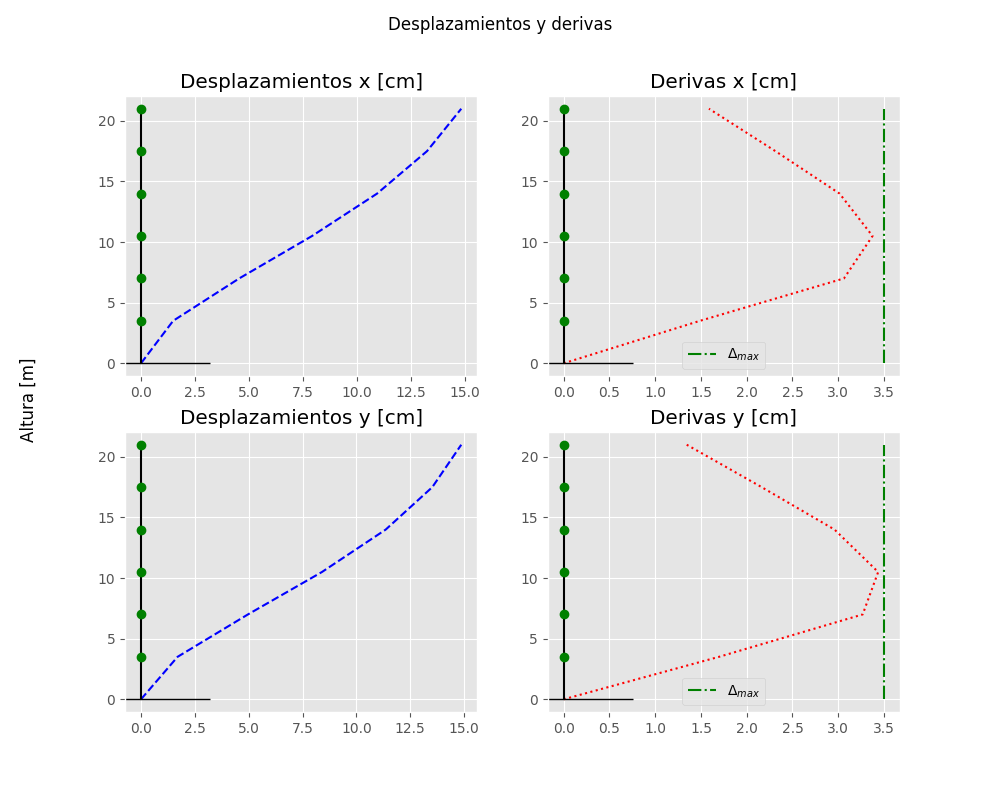

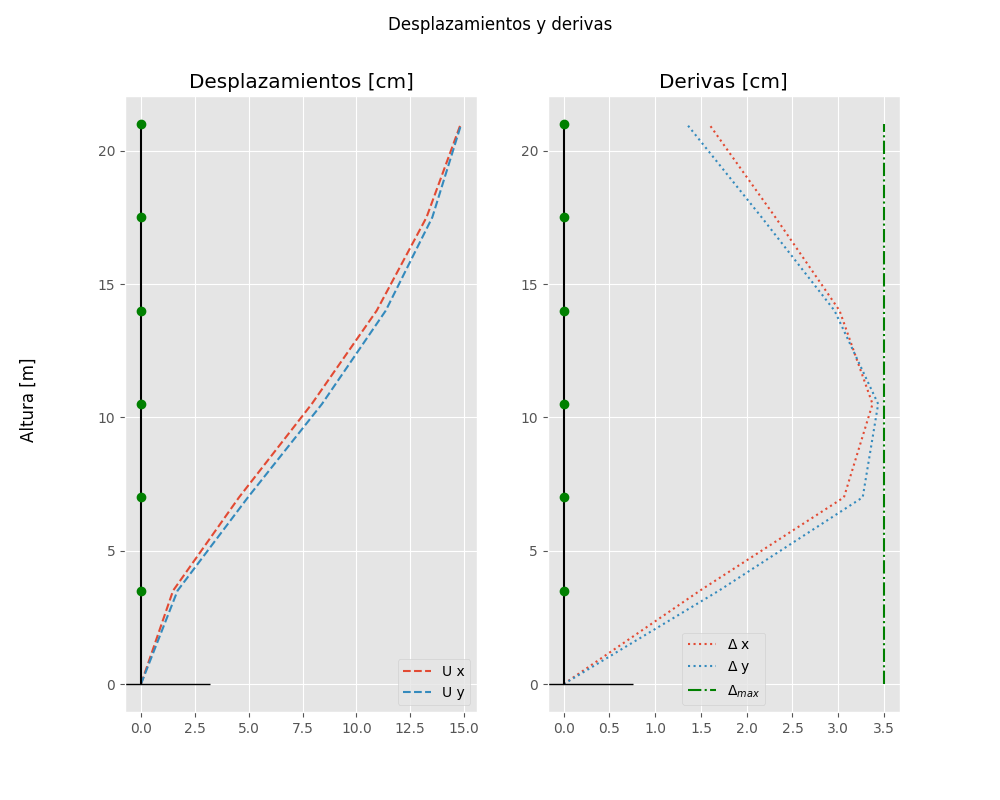

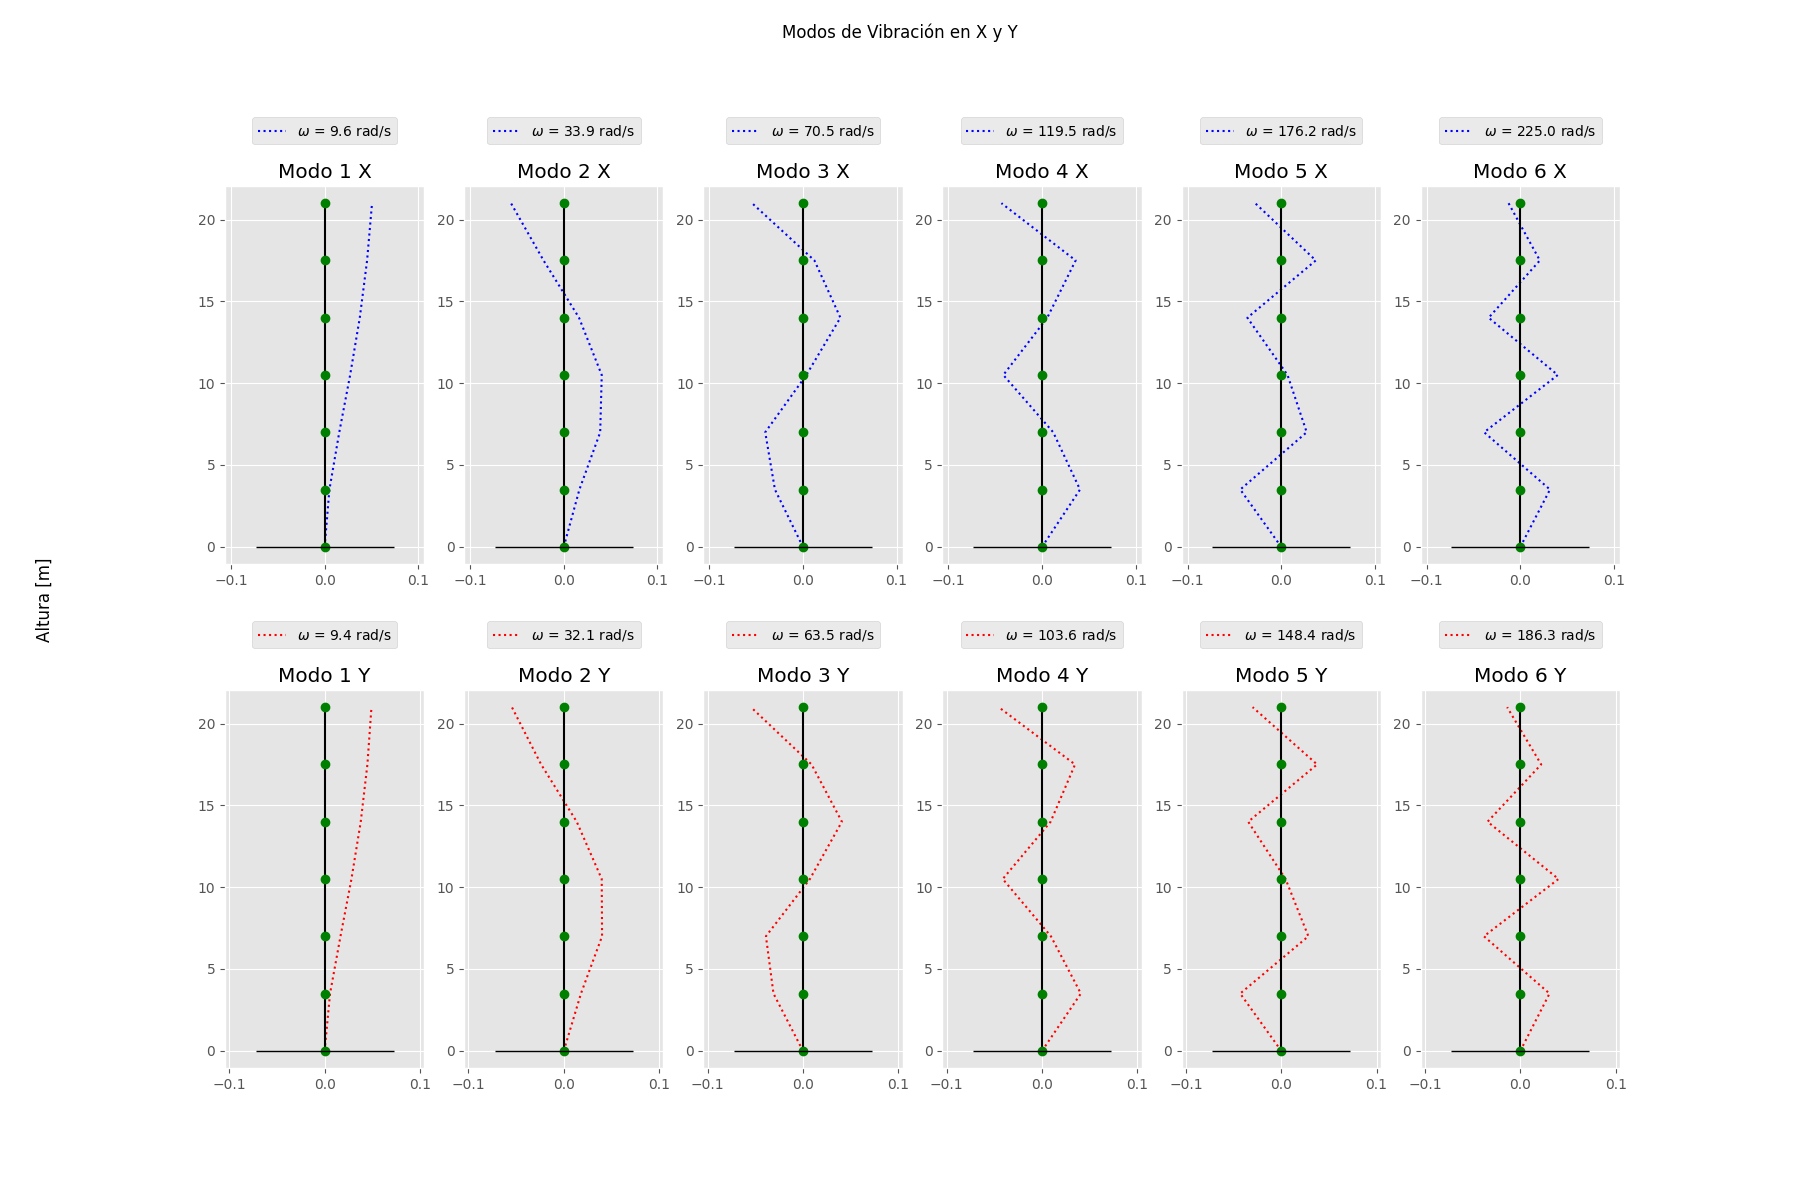

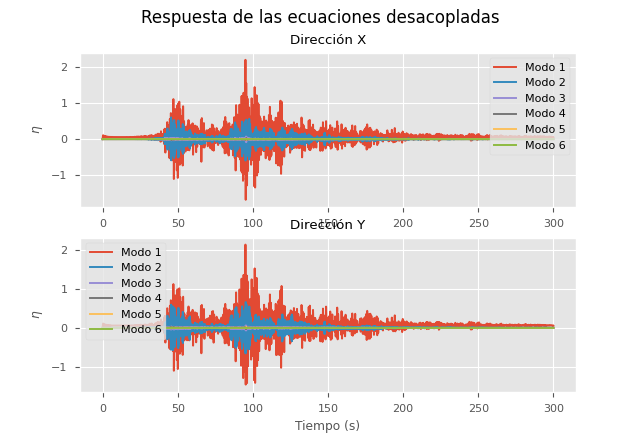

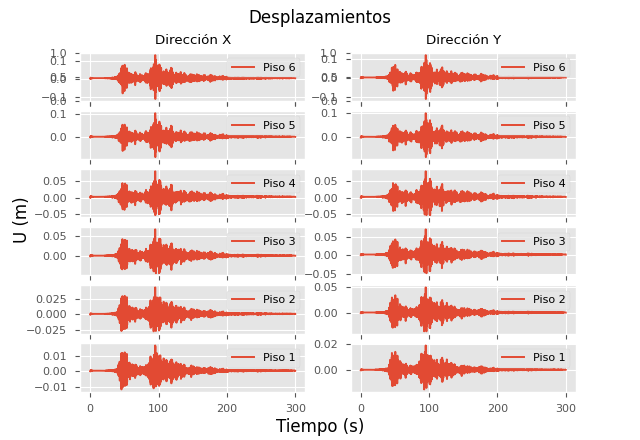

In [12]:
graf_estruct = np.insert(h_acumu,0,0)
graf_U = np.vstack(
    [np.zeros(2), np.c_[U_x, U_y]])
graf_Urel = np.vstack(
    [np.zeros(2), np.c_[U_rel_x, U_rel_y]])
graf_Phi_x = np.concatenate((np.zeros((1,N_PISOS)),Phi_x))
graf_Phi_y = np.concatenate((np.zeros((1,N_PISOS)),Phi_y))

# DESPLAZAMIENTOS
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.supylabel('Altura [m]')
fig.suptitle('Desplazamientos y derivas')
for i in range(2):
    dir = "x" if i==0 else "y"
    ax = fig.add_subplot(2,2,2*i+1)
    ax.grid(visible=True)
    ax.plot(graf_U[:,i], graf_estruct, '--b')
    ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
    ax.plot(np.zeros(N_PISOS+1)[1:], graf_estruct[1:], 'og')
    ax.plot(0,0,'_k', markersize=100)
    ax.set_title(f"Desplazamientos {dir} [cm]")
    ax = fig.add_subplot(2,2,2*i+2)
    ax.grid(visible=True)
    ax.plot(graf_Urel[:,i], graf_estruct, ':r')
    ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
    ax.plot(np.zeros(N_PISOS+1)[1:], graf_estruct[1:], 'og')
    ax.plot(np.zeros(N_PISOS+1)+DeltaMAX, graf_estruct, '-.g', label=r'$\Delta_{max}$')
    ax.plot(0,0,'_k', markersize=100)
    ax.legend()
    ax.set_title(f"Derivas {dir} [cm]")
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 8)
fig.supylabel('Altura [m]')
fig.suptitle('Desplazamientos y derivas')

ax = fig.add_subplot(1,2,1)
ax.grid(visible=True)
ax.plot(graf_U[:,0], graf_estruct, '--', label='U x')
ax.plot(graf_U[:,1], graf_estruct, '--', label='U y')
ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
ax.plot(np.zeros(N_PISOS+1)[1:], graf_estruct[1:], 'og')
ax.plot(0,0,'_k', markersize=100)
ax.legend()
ax.set_title("Desplazamientos [cm]")

ax = fig.add_subplot(1,2,2)
ax.grid(visible=True)
ax.plot(graf_Urel[:,0], graf_estruct, ':', label=r'$\Delta$ x')
ax.plot(graf_Urel[:,1], graf_estruct, ':', label=r'$\Delta$ y')
ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
ax.plot(np.zeros(N_PISOS+1)[1:], graf_estruct[1:], 'og')
ax.plot(np.zeros(N_PISOS+1)+DeltaMAX, graf_estruct, '-.g', label=r'$\Delta_{max}$')
ax.plot(0,0,'_k', markersize=100)
ax.legend()
ax.set_title(f"Derivas [cm]")
plt.show()

# MODOS
fig = plt.figure()
fig.set_size_inches(18, 12)
fig.suptitle("Modos de Vibración en X y Y")
fig.supylabel('Altura [m]')
for i in range(N_PISOS):
    ax = fig.add_subplot(2,N_PISOS,1+i)
    ax.grid(visible=True)
    ax.plot(graf_Phi_x[:,i], graf_estruct, ':b', label=r"$\omega$"+f" = {ome_x[i].round(1)} rad/s")
    ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
    ax.plot(np.zeros(N_PISOS+1), graf_estruct, 'og')
    ax.plot(0,0,'_k', markersize=100)
    ax.set_title(f"Modo {i+1} X")
    lim = np.max(abs(Phi_x))+0.05
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.9])
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.2))
    ax.set_xlim([-lim, lim])

    ax = fig.add_subplot(2,N_PISOS,1+N_PISOS+i)
    ax.grid(visible=True)
    ax.plot(graf_Phi_y[:,i], graf_estruct, ':r', label=r"$\omega$"+f" = {ome_y[i].round(1)} rad/s")
    ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
    ax.plot(np.zeros(N_PISOS+1), graf_estruct, 'og')
    ax.plot(0,0,'_k', markersize=100)
    ax.set_title(f"Modo {i+1} Y")
    lim = np.max(abs(Phi_y))+0.05
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.9])
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.2))
    ax.set_xlim([-lim, lim])
plt.show()

plt.style.use('seaborn-paper')

# TIEMPO HISTORIA
fig = plt.figure()
fig.suptitle("Respuesta de las ecuaciones desacopladas")
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)

ax1.plot(Japon2011[:,0], th_eta[X].T, label=[f'Modo {i+1}' for i in range(N_PISOS)])
ax1.set_title('Dirección X')
# ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel(r'$\eta$')
ax1.legend()

ax2.plot(Japon2011[:,0], th_eta[Y].T, label=[f'Modo {i+1}' for i in range(N_PISOS)])
ax2.set_title('Dirección Y')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel(r'$\eta$')
ax2.legend()
plt.show()

fig = plt.figure()
fig.suptitle("Desplazamientos")
fig.supylabel("U (m)")
fig.supxlabel('Tiempo (s)')
ax1 = fig.add_subplot(N_PISOS,2,1)
ax1.set_title('Dirección X')
# ax1.set_xlabel('Tiempo (s)')
ax2 = fig.add_subplot(N_PISOS,2,2)
ax2.set_title('Dirección Y')
# ax2.set_xlabel('Tiempo (s)')
for piso in range(N_PISOS):
    ax = fig.add_subplot(N_PISOS,2,2*piso+1, sharex=ax1)
    ax.plot(Japon2011[:,0], th_U[X][N_PISOS-piso-1,:], label=f'Piso {N_PISOS-piso}')
    ax.legend()
    ax=fig.add_subplot(N_PISOS,2,2*piso+2, sharex=ax2)
    ax.plot(Japon2011[:,0], th_U[Y][N_PISOS-piso-1,:], label=f'Piso {N_PISOS-piso}')
    ax.legend()
plt.show()

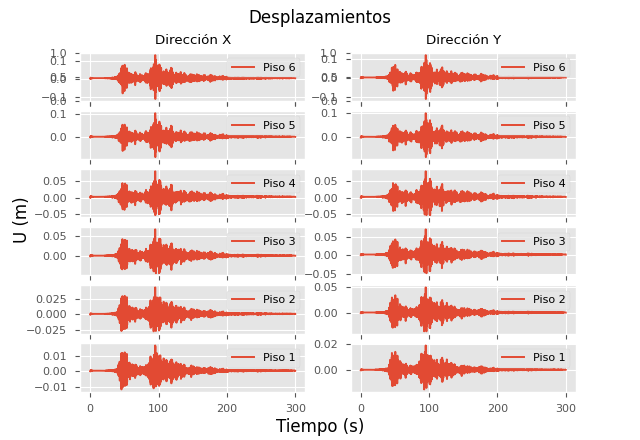

In [13]:
# Desplazamientos máximos en cada piso

fig = plt.figure()
fig.suptitle("Desplazamientos")
fig.supylabel("U (m)")
fig.supxlabel('Tiempo (s)')
ax1 = fig.add_subplot(N_PISOS,2,1)
ax1.set_title('Dirección X')
# ax1.set_xlabel('Tiempo (s)')
ax2 = fig.add_subplot(N_PISOS,2,2)
ax2.set_title('Dirección Y')
# ax2.set_xlabel('Tiempo (s)')
for piso in range(N_PISOS):
    ax = fig.add_subplot(N_PISOS,2,2*piso+1, sharex=ax1)
    ax.plot(Japon2011[:,0], th_U[X][N_PISOS-piso-1,:], label=f'Piso {N_PISOS-piso}')
    ax.legend()
    ax=fig.add_subplot(N_PISOS,2,2*piso+2, sharex=ax2)
    ax.plot(Japon2011[:,0], th_U[Y][N_PISOS-piso-1,:], label=f'Piso {N_PISOS-piso}')
    ax.legend()
plt.show()

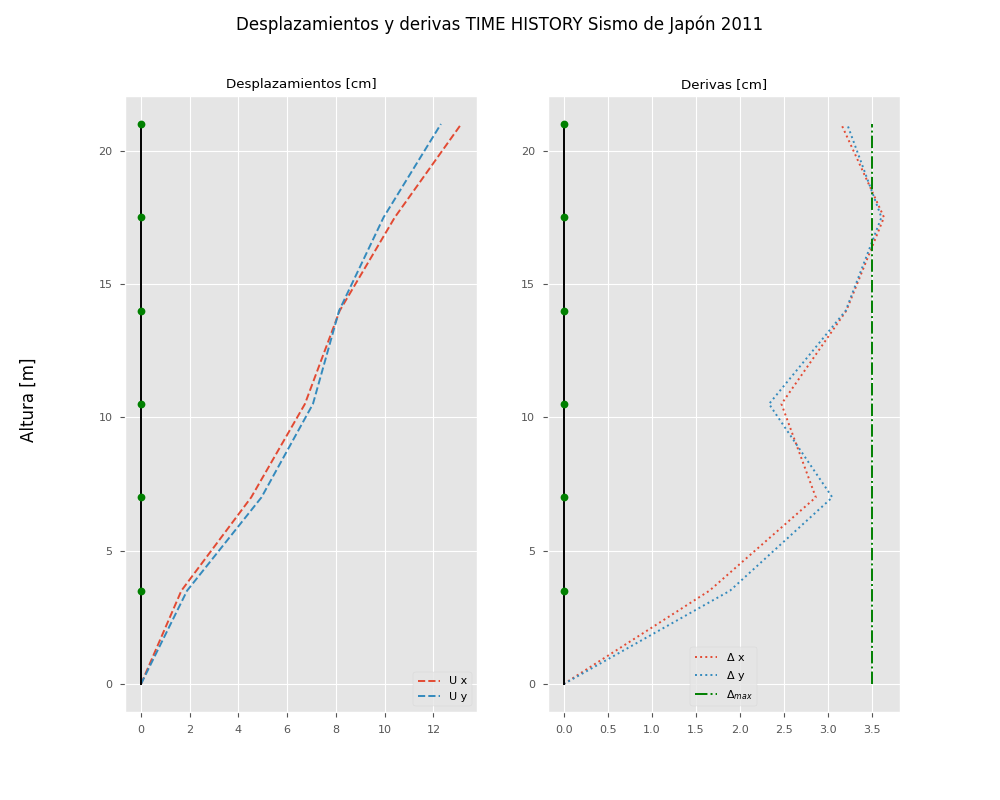

In [14]:
th_U_max = np.vstack((np.max(abs(th_U[X]), axis=1), np.max(abs(th_U[Y]), axis=1)))
th_Der_X = th_U[X] - np.vstack((np.zeros(instantes), th_U[X][:-1,:]))
th_Der_Y = th_U[Y] - np.vstack((np.zeros(instantes), th_U[Y][:-1,:]))
th_Der_max = np.vstack((np.max(abs(th_Der_X), axis=1), np.max(abs(th_Der_Y), axis=1)))
#th_Der_max = th_U_max - np.hstack((np.zeros((2,1)), th_U_max[:,:-1]))
graf_U_th = np.hstack((np.zeros((2,1)), th_U_max))*100
graf_Urel_th = np.hstack((np.zeros((2,1)), th_Der_max))*100
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.supylabel('Altura [m]')
fig.suptitle('Desplazamientos y derivas TIME HISTORY Sismo de Japón 2011')

ax = fig.add_subplot(1,2,1)
ax.grid(visible=True)
ax.plot(graf_U_th[0,:], graf_estruct, '--', label='U x')
ax.plot(graf_U_th[1,:], graf_estruct, '--', label='U y')
ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
ax.plot(np.zeros(N_PISOS+1)[1:], graf_estruct[1:], 'og')
ax.plot(0,0,'_k', markersize=100)
ax.legend()
ax.set_title("Desplazamientos [cm]")

ax = fig.add_subplot(1,2,2)
ax.grid(visible=True)
ax.plot(graf_Urel_th[0,:], graf_estruct, ':', label=r'$\Delta$ x')
ax.plot(graf_Urel_th[1,:], graf_estruct, ':', label=r'$\Delta$ y')
ax.plot(np.zeros(N_PISOS+1), graf_estruct, '-k')
ax.plot(np.zeros(N_PISOS+1)[1:], graf_estruct[1:], 'og')
ax.plot(np.zeros(N_PISOS+1)+DeltaMAX, graf_estruct, '-.g', label=r'$\Delta_{max}$')
ax.plot(0,0,'_k', markersize=100)
ax.legend()
ax.set_title(f"Derivas [cm]")
plt.show()

In [15]:
th_Der_max

array([[0.0165636 , 0.02865197, 0.02474626, 0.03212284, 0.0364026 ,
        0.03153779],
       [0.01890388, 0.03052851, 0.02333688, 0.03205075, 0.03611185,
        0.03221028]])